# IDA and EDA Analysis

## Datasets


In [8]:
#imports
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('../data/final_df.csv')

In [7]:
df.describe()

,text_length,sentiment_compound,sentiment_positive,sentiment_negative,sentiment_neutral,sentiment_subjectivity,likes,replies,platform_post_score,platform_post_engagement,...,exclamation_count,question_count,period_count,engagement_score,engagement_log,is_positive,is_negative,is_neutral,sentiment_magnitude,community_size
count,2985.000000,2985.000000,2985.000000,2985.000000,2985.000000,2985.000000,2985.000000,2985.000000,2985.000000,2985.000000,...,2985.000000,2985.000000,2985.000000,2985.000000,2967.000000,2985.000000,2985.000000,2985.000000,2985.000000,2985.000000
mean,69.411390,0.269348,0.122410,0.070988,0.806602,0.395037,39.279397,1.701173,17278.596985,2021.963819,...,0.187270,0.422781,4.135678,42.681742,-inf,0.667002,0.303518,0.029481,0.612688,177.364489
std,53.427404,0.612767,0.089129,0.074467,0.097259,0.170976,466.264289,9.291551,26399.024761,2511.834107,...,0.749959,1.109376,4.378079,475.239958,NaN,0.471365,0.459854,0.169178,0.269340,121.518185
min,10.000000,-0.997700,0.000000,0.000000,0.295000,0.000000,-17.000000,0.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,-15.000000,-inf,0.000000,0.000000,0.000000,0.000000,2.000000
25%,31.000000,-0.331000,0.061000,0.000000,0.750000,0.271150,0.000000,0.000000,62.000000,85.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.415200,97.000000
50%,52.000000,0.458800,0.113000,0.054000,0.817000,0.392250,1.000000,0.000000,7378.000000,1040.000000,...,0.000000,0.000000,3.000000,1.000000,0.693147,1.000000,0.000000,0.000000,0.648600,100.000000
75%,92.000000,0.804700,0.170000,0.109000,0.874000,0.507500,3.000000,1.000000,21203.000000,2695.000000,...,0.000000,0.000000,6.000000,5.000000,1.791759,1.000000,1.000000,0.000000,0.854700,271.000000
max,300.000000,0.996800,0.705000,0.519000,1.000000,0.986600,19730.000000,285.000000,119905.000000,8726.000000,...,18.000000,19.000000,45.000000,19778.000000,9.892376,1.000000,1.000000,1.000000,0.997700,405.000000


## Visualizations

In [ ]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [9]:
df['created_at'] = pd.to_datetime(df['created_at'])

### INITIAL DATA ANALYSIS

In [11]:
# Basic Info
print("\n📊 DATASET OVERVIEW")
print("-" * 80)
print(f"Total Comments: {len(df):,}")
print(f"Total Columns: {len(df.columns)}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data Quality
print("\n🔍 DATA QUALITY")
print("-" * 80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
}).sort_values('Missing', ascending=False)
print(missing_df[missing_df['Missing'] > 0])

if missing_df['Missing'].sum() == 0:
    print("✓ No missing values detected!")

# Temporal Coverage
print("\n📅 TEMPORAL COVERAGE")
print("-" * 80)
print(f"Date Range: {df['created_at'].min()} to {df['created_at'].max()}")
print(f"Time Span: {(df['created_at'].max() - df['created_at'].min()).days} days")
print(f"\nComments by Year:")
print(df['year'].value_counts().sort_index())

# Platform Distribution
print("\n🌐 PLATFORM DISTRIBUTION")
print("-" * 80)
platform_stats = df.groupby('source').agg({
    'text': 'count',
    'likes': 'mean',
    'replies': 'mean',
    'engagement_score': 'mean',
    'word_count': 'mean'
}).round(2)
platform_stats.columns = ['Count', 'Avg Likes', 'Avg Replies', 'Avg Engagement', 'Avg Words']
print(platform_stats)

# Sentiment Overview
print("\n😊 SENTIMENT OVERVIEW")
print("-" * 80)
print(f"Positive: {df['is_positive'].sum():,} ({df['is_positive'].mean()*100:.1f}%)")
print(f"Negative: {df['is_negative'].sum():,} ({df['is_negative'].mean()*100:.1f}%)")
print(f"Neutral:  {df['is_neutral'].sum():,} ({df['is_neutral'].mean()*100:.1f}%)")
print(f"\nAverage VADER Scores:")
print(f"  Compound:  {df['sentiment_compound'].mean():.3f} (±{df['sentiment_compound'].std():.3f})")
print(f"  Positive:  {df['sentiment_positive'].mean():.3f}")
print(f"  Negative:  {df['sentiment_negative'].mean():.3f}")
print(f"  Neutral:   {df['sentiment_neutral'].mean():.3f}")

# Text Statistics
print("\n📝 TEXT STATISTICS")
print("-" * 80)
print(f"Average Word Count: {df['word_count'].mean():.1f} (±{df['word_count'].std():.1f})")
print(f"Median Word Count: {df['word_count'].median():.0f}")
print(f"Word Count Range: {df['word_count'].min():.0f} - {df['word_count'].max():.0f}")

# Engagement Statistics
print("\n💬 ENGAGEMENT STATISTICS")
print("-" * 80)
print(f"Average Likes: {df['likes'].mean():.1f} (Median: {df['likes'].median():.0f})")
print(f"Average Replies: {df['replies'].mean():.1f} (Median: {df['replies'].median():.0f})")
print(f"Total Engagement: {df['engagement_score'].sum():,.0f}")

# Top Communities
print("\n🏆 TOP 10 COMMUNITIES")
print("-" * 80)
top_communities = df['platform_community'].value_counts().head(10)
for i, (community, count) in enumerate(top_communities.items(), 1):
    print(f"{i:2d}. {community[:50]}: {count:,} comments")

# Content Flags
print("\n🏷️ CONTENT CATEGORIES")
print("-" * 80)
print(f"Contains AI keywords: {df['contains_ai'].sum():,} ({df['contains_ai'].mean()*100:.1f}%)")
print(f"Contains Opinion keywords: {df['contains_opinion'].sum():,} ({df['contains_opinion'].mean()*100:.1f}%)")
print(f"Contains Societal keywords: {df['contains_societal'].sum():,} ({df['contains_societal'].mean()*100:.1f}%)")



📊 DATASET OVERVIEW
--------------------------------------------------------------------------------
Total Comments: 2,985
Total Columns: 39
Memory Usage: 7.19 MB

🔍 DATA QUALITY
--------------------------------------------------------------------------------
                Missing  Percentage
engagement_log       18    0.603015

📅 TEMPORAL COVERAGE
--------------------------------------------------------------------------------
Date Range: 2021-10-20 04:04:18+00:00 to 2025-12-07 04:55:25+00:00
Time Span: 1509 days

Comments by Year:
year
2021      38
2022      57
2023     459
2024     538
2025    1893
Name: count, dtype: int64

🌐 PLATFORM DISTRIBUTION
--------------------------------------------------------------------------------
         Count  Avg Likes  Avg Replies  Avg Engagement  Avg Words
source                                                           
reddit    1007       4.40         0.72            5.84      86.97
youtube   1978      57.04         2.20           61.44     

✓ Saved: sentiment_distribution.png


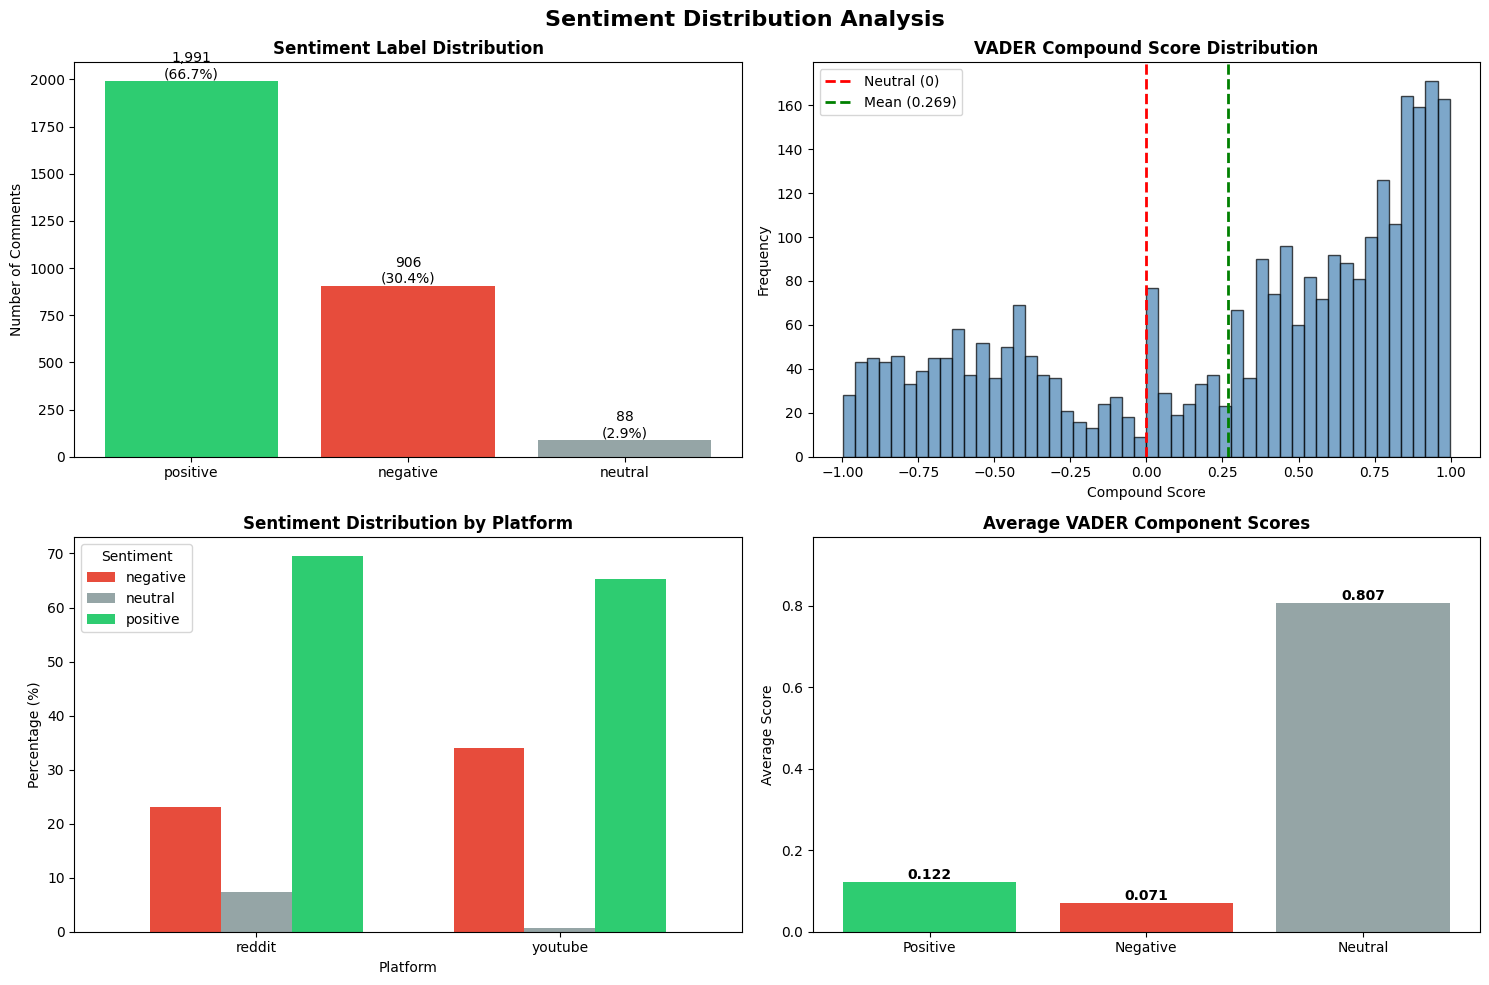

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sentiment Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Sentiment Label Counts
sentiment_counts = df['sentiment_label'].value_counts()
colors = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}
ax = axes[0, 0]
bars = ax.bar(sentiment_counts.index, sentiment_counts.values, 
              color=[colors[x] for x in sentiment_counts.index])
ax.set_title('Sentiment Label Distribution', fontweight='bold')
ax.set_ylabel('Number of Comments')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom')

# 2. VADER Compound Score Distribution
ax = axes[0, 1]
ax.hist(df['sentiment_compound'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral (0)')
ax.axvline(df['sentiment_compound'].mean(), color='green', linestyle='--', 
           linewidth=2, label=f'Mean ({df["sentiment_compound"].mean():.3f})')
ax.set_title('VADER Compound Score Distribution', fontweight='bold')
ax.set_xlabel('Compound Score')
ax.set_ylabel('Frequency')
ax.legend()

# 3. Sentiment by Platform
ax = axes[1, 0]
sentiment_platform = pd.crosstab(df['source'], df['sentiment_label'], normalize='index') * 100
sentiment_platform.plot(kind='bar', ax=ax, color=[colors[x] for x in sentiment_platform.columns], 
                       rot=0, width=0.7)
ax.set_title('Sentiment Distribution by Platform', fontweight='bold')
ax.set_xlabel('Platform')
ax.set_ylabel('Percentage (%)')
ax.legend(title='Sentiment')

# 4. VADER Component Scores
ax = axes[1, 1]
vader_scores = df[['sentiment_positive', 'sentiment_negative', 'sentiment_neutral']].mean()
bars = ax.bar(['Positive', 'Negative', 'Neutral'], vader_scores.values,
              color=['#2ecc71', '#e74c3c', '#95a5a6'])
ax.set_title('Average VADER Component Scores', fontweight='bold')
ax.set_ylabel('Average Score')
ax.set_ylim(0, max(vader_scores.values) * 1.2)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
# plt.savefig('../figures/sentiment_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: sentiment_distribution.png")
plt.show()

✓ Saved: temporal_trends.png


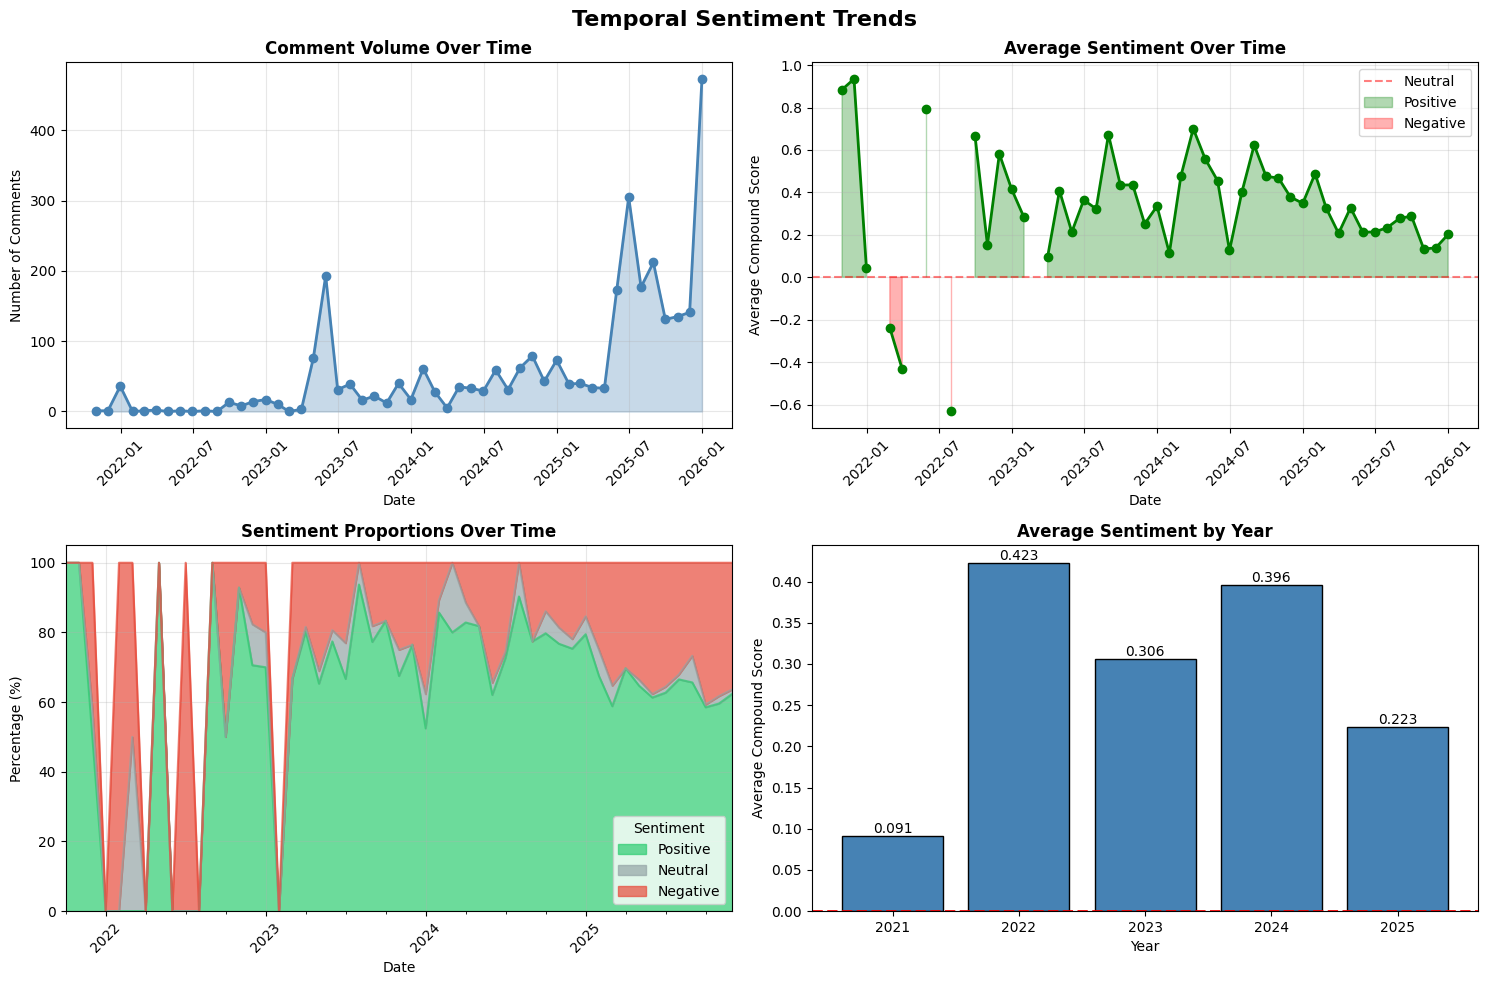

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Temporal Sentiment Trends', fontsize=16, fontweight='bold')

# 1. Comments Over Time
ax = axes[0, 0]
df_time = df.set_index('created_at').resample('M').size()
ax.plot(df_time.index, df_time.values, marker='o', linewidth=2, color='steelblue')
ax.fill_between(df_time.index, df_time.values, alpha=0.3, color='steelblue')
ax.set_title('Comment Volume Over Time', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Comments')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 2. Average Sentiment Over Time
ax = axes[0, 1]
df_sentiment = df.set_index('created_at').resample('M')['sentiment_compound'].mean()
ax.plot(df_sentiment.index, df_sentiment.values, marker='o', linewidth=2, color='green')
ax.axhline(0, color='red', linestyle='--', alpha=0.5, label='Neutral')
ax.fill_between(df_sentiment.index, df_sentiment.values, 0, 
                where=(df_sentiment.values > 0), alpha=0.3, color='green', label='Positive')
ax.fill_between(df_sentiment.index, df_sentiment.values, 0,
                where=(df_sentiment.values < 0), alpha=0.3, color='red', label='Negative')
ax.set_title('Average Sentiment Over Time', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Compound Score')
ax.legend()
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 3. Sentiment Proportions Over Time
ax = axes[1, 0]
df_sentiment_pct = df.set_index('created_at').resample('M').apply(
    lambda x: pd.Series({
        'Positive': (x['is_positive'].sum() / len(x)) * 100,
        'Neutral': (x['is_neutral'].sum() / len(x)) * 100,
        'Negative': (x['is_negative'].sum() / len(x)) * 100
    })
)
df_sentiment_pct.plot(kind='area', stacked=True, ax=ax,
                     color=['#2ecc71', '#95a5a6', '#e74c3c'], alpha=0.7)
ax.set_title('Sentiment Proportions Over Time', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Percentage (%)')
ax.legend(title='Sentiment')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 4. Yearly Sentiment Comparison
ax = axes[1, 1]
yearly_sentiment = df.groupby('year')['sentiment_compound'].mean()
bars = ax.bar(yearly_sentiment.index, yearly_sentiment.values, color='steelblue', edgecolor='black')
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_title('Average Sentiment by Year', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Average Compound Score')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.savefig('temporal_trends.png', dpi=300, bbox_inches='tight')
print("✓ Saved: temporal_trends.png")
plt.show()

✓ Saved: engagement_analysis.png


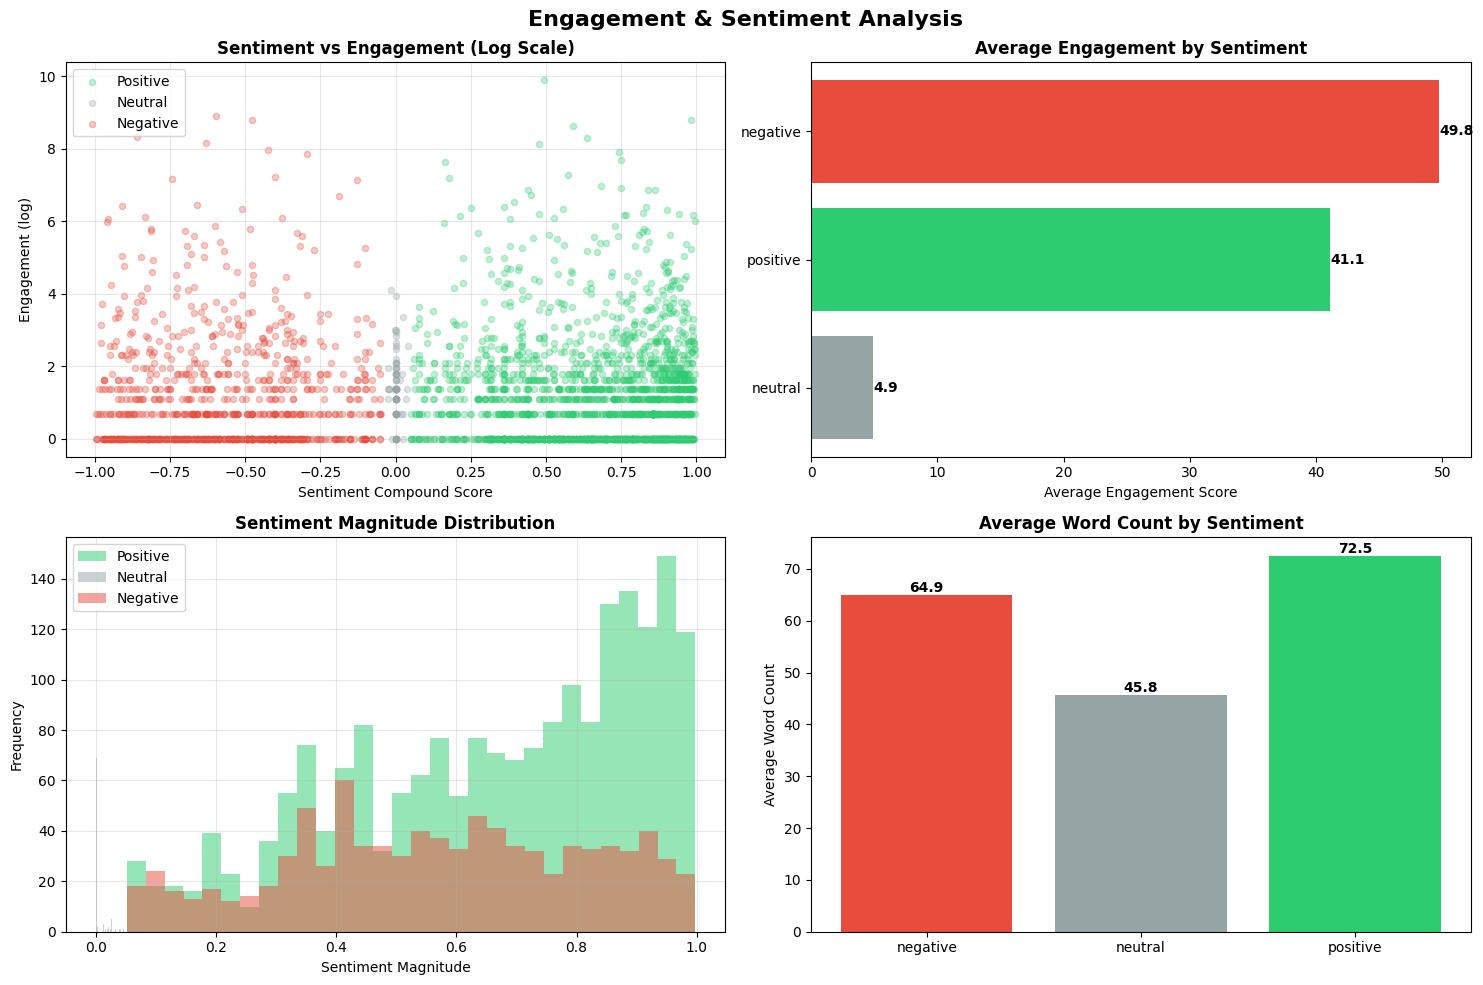

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Engagement & Sentiment Analysis', fontsize=16, fontweight='bold')

# 1. Sentiment vs Engagement
ax = axes[0, 0]
colors = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}
for sentiment in ['positive', 'neutral', 'negative']:
    mask = df['sentiment_label'] == sentiment
    ax.scatter(df[mask]['sentiment_compound'], df[mask]['engagement_log'],
              alpha=0.3, s=20, color=colors[sentiment], label=sentiment.capitalize())
ax.set_title('Sentiment vs Engagement (Log Scale)', fontweight='bold')
ax.set_xlabel('Sentiment Compound Score')
ax.set_ylabel('Engagement (log)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Average Engagement by Sentiment
ax = axes[0, 1]
engagement_by_sentiment = df.groupby('sentiment_label')['engagement_score'].mean().sort_values()
bars = ax.barh(engagement_by_sentiment.index, engagement_by_sentiment.values,
               color=[colors[x] for x in engagement_by_sentiment.index])
ax.set_title('Average Engagement by Sentiment', fontweight='bold')
ax.set_xlabel('Average Engagement Score')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.1f}', ha='left', va='center', fontweight='bold')

# 3. Sentiment Magnitude Distribution
ax = axes[1, 0]
for sentiment in ['positive', 'neutral', 'negative']:
    mask = df['sentiment_label'] == sentiment
    ax.hist(df[mask]['sentiment_magnitude'], bins=30, alpha=0.5,
           label=sentiment.capitalize(), color=colors[sentiment])
ax.set_title('Sentiment Magnitude Distribution', fontweight='bold')
ax.set_xlabel('Sentiment Magnitude')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Word Count vs Sentiment
ax = axes[1, 1]
sentiment_wordcount = df.groupby('sentiment_label')['word_count'].mean()
bars = ax.bar(sentiment_wordcount.index, sentiment_wordcount.values,
              color=[colors[x] for x in sentiment_wordcount.index])
ax.set_title('Average Word Count by Sentiment', fontweight='bold')
ax.set_ylabel('Average Word Count')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
# plt.savefig('engagement_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: engagement_analysis.png")
plt.show()

✓ Saved: platform_comparison.png


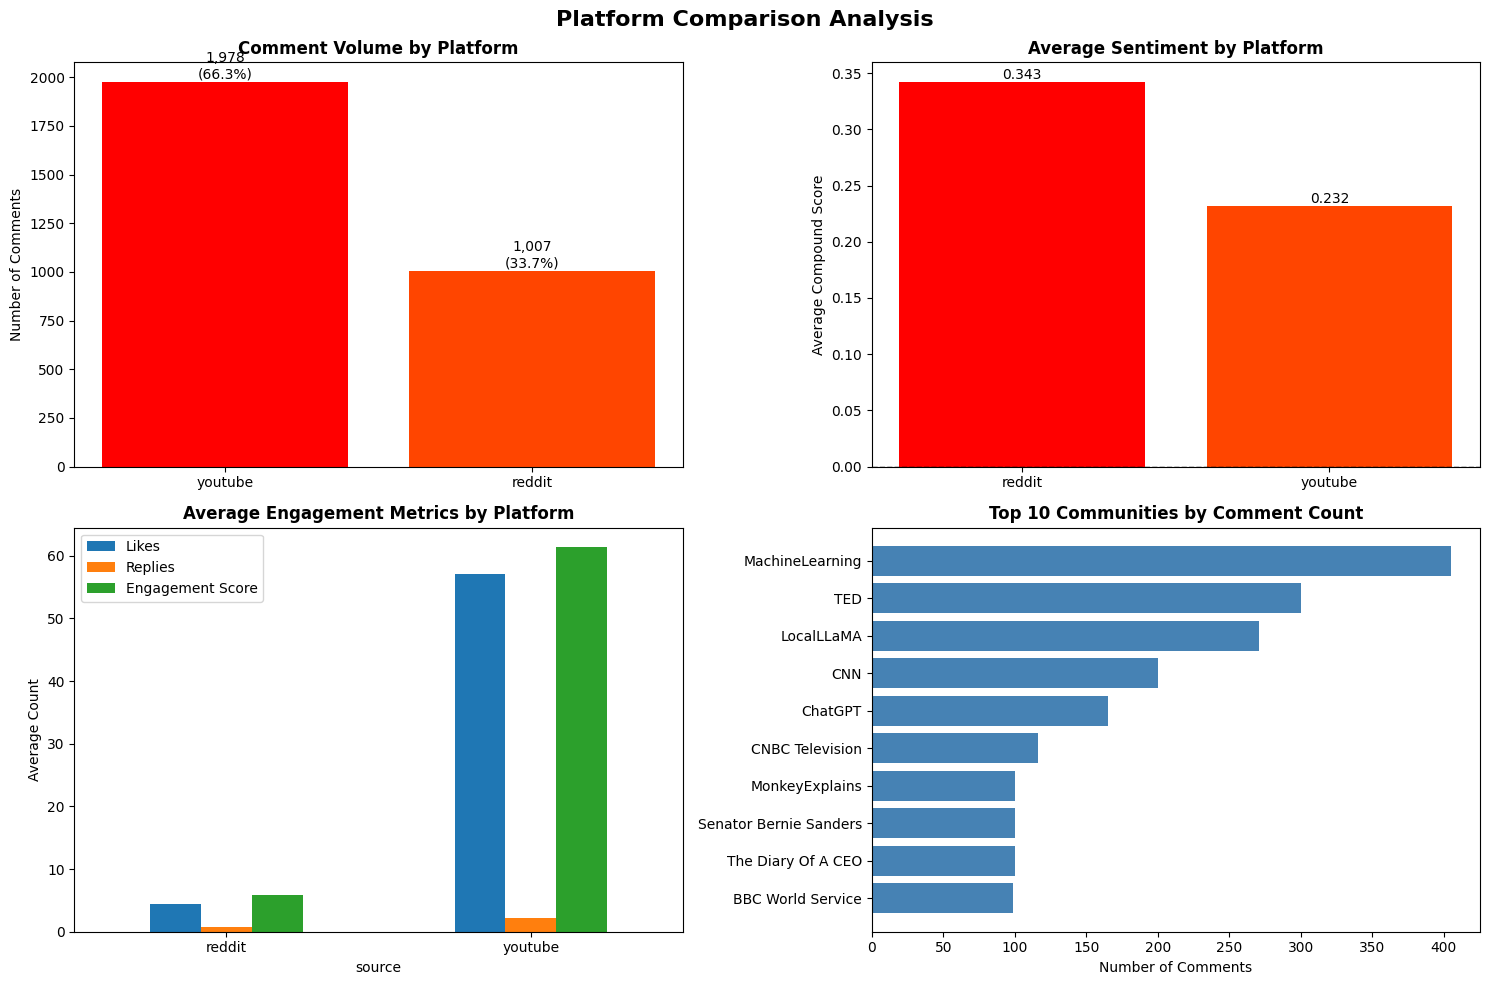

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Platform Comparison Analysis', fontsize=16, fontweight='bold')

# 1. Comment Volume by Platform
ax = axes[0, 0]
platform_counts = df['source'].value_counts()
bars = ax.bar(platform_counts.index, platform_counts.values, color=['#FF0000', '#FF4500'])
ax.set_title('Comment Volume by Platform', fontweight='bold')
ax.set_ylabel('Number of Comments')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom')

# 2. Average Sentiment by Platform
ax = axes[0, 1]
platform_sentiment = df.groupby('source')['sentiment_compound'].mean()
bars = ax.bar(platform_sentiment.index, platform_sentiment.values, color=['#FF0000', '#FF4500'])
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_title('Average Sentiment by Platform', fontweight='bold')
ax.set_ylabel('Average Compound Score')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top')

# 3. Engagement Comparison
ax = axes[1, 0]
engagement_comparison = df.groupby('source')[['likes', 'replies', 'engagement_score']].mean()
engagement_comparison.plot(kind='bar', ax=ax, rot=0)
ax.set_title('Average Engagement Metrics by Platform', fontweight='bold')
ax.set_ylabel('Average Count')
ax.legend(['Likes', 'Replies', 'Engagement Score'])

# 4. Top Communities
ax = axes[1, 1]
top_communities = df['platform_community'].value_counts().head(10)
ax.barh(range(len(top_communities)), top_communities.values, color='steelblue')
ax.set_yticks(range(len(top_communities)))
ax.set_yticklabels([c[:30] + '...' if len(c) > 30 else c for c in top_communities.index])
ax.set_title('Top 10 Communities by Comment Count', fontweight='bold')
ax.set_xlabel('Number of Comments')
ax.invert_yaxis()

plt.tight_layout()
# plt.savefig('platform_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: platform_comparison.png")
plt.show()


✓ Saved: content_analysis.png


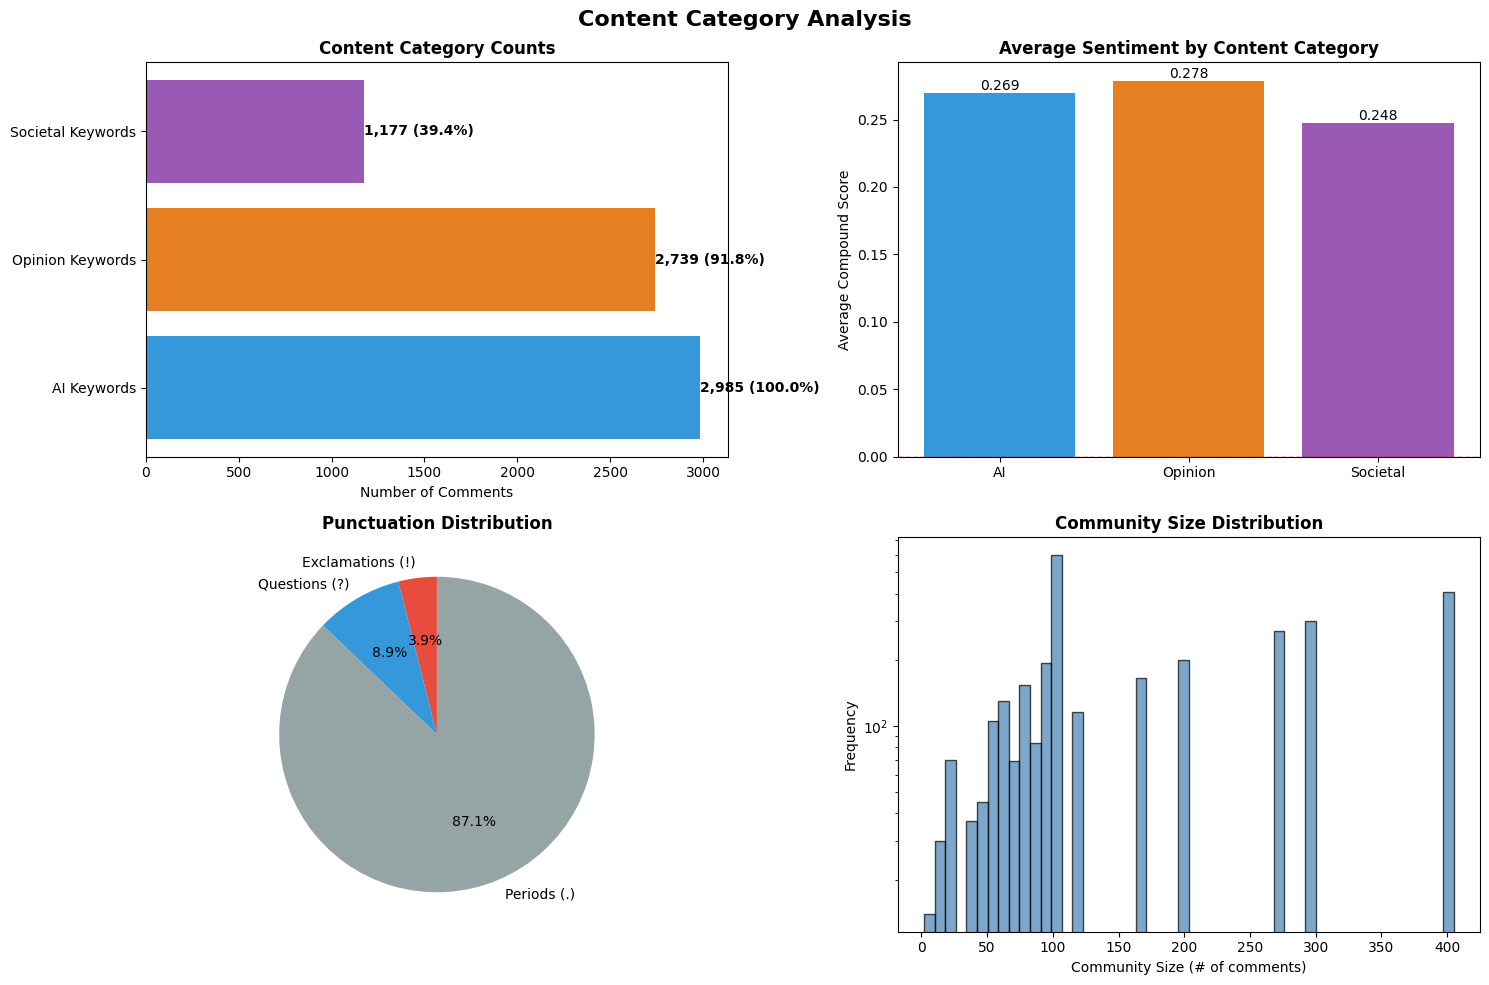

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Content Category Analysis', fontsize=16, fontweight='bold')

# 1. Content Category Distribution
ax = axes[0, 0]
category_counts = pd.DataFrame({
    'AI Keywords': [df['contains_ai'].sum()],
    'Opinion Keywords': [df['contains_opinion'].sum()],
    'Societal Keywords': [df['contains_societal'].sum()]
}).T
bars = ax.barh(category_counts.index, category_counts[0].values, color=['#3498db', '#e67e22', '#9b59b6'])
ax.set_title('Content Category Counts', fontweight='bold')
ax.set_xlabel('Number of Comments')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{int(width):,} ({width/len(df)*100:.1f}%)',
            ha='left', va='center', fontweight='bold')

# 2. Sentiment by Content Category
ax = axes[0, 1]
categories = ['contains_ai', 'contains_opinion', 'contains_societal']
category_labels = ['AI', 'Opinion', 'Societal']
sentiment_by_category = []
for cat in categories:
    sentiment_by_category.append(df[df[cat] == True]['sentiment_compound'].mean())
bars = ax.bar(category_labels, sentiment_by_category, color=['#3498db', '#e67e22', '#9b59b6'])
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_title('Average Sentiment by Content Category', fontweight='bold')
ax.set_ylabel('Average Compound Score')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top')

# 3. Punctuation Usage
ax = axes[1, 0]
punctuation = df[['exclamation_count', 'question_count', 'period_count']].sum()
ax.pie(punctuation.values, labels=['Exclamations (!)', 'Questions (?)', 'Periods (.)'],
       autopct='%1.1f%%', startangle=90, colors=['#e74c3c', '#3498db', '#95a5a6'])
ax.set_title('Punctuation Distribution', fontweight='bold')

# 4. Community Size Distribution
ax = axes[1, 1]
ax.hist(df['community_size'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_title('Community Size Distribution', fontweight='bold')
ax.set_xlabel('Community Size (# of comments)')
ax.set_ylabel('Frequency')
ax.set_yscale('log')

plt.tight_layout()
# plt.savefig('content_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: content_analysis.png")
plt.show()

In [17]:
print("\n" + "="*80)
print("SUMMARY STATISTICS & KEY FINDINGS")
print("="*80)

# Overall sentiment
overall_sentiment = df['sentiment_compound'].mean()
print(f"\n📊 OVERALL SENTIMENT: {overall_sentiment:.3f}")
if overall_sentiment > 0.05:
    sentiment_desc = "POSITIVE ✓"
elif overall_sentiment < -0.05:
    sentiment_desc = "NEGATIVE ✗"
else:
    sentiment_desc = "NEUTRAL ○"
print(f"   Interpretation: {sentiment_desc}")

# Platform comparison
print(f"\n🌐 PLATFORM SENTIMENT COMPARISON:")
for platform in df['source'].unique():
    platform_sentiment = df[df['source'] == platform]['sentiment_compound'].mean()
    print(f"   {platform.capitalize()}: {platform_sentiment:.3f}")

# Temporal trends
print(f"\n📈 TEMPORAL TRENDS:")
yearly_sentiment = df.groupby('year')['sentiment_compound'].mean()
if len(yearly_sentiment) > 1:
    trend = "IMPROVING" if yearly_sentiment.iloc[-1] > yearly_sentiment.iloc[0] else "DECLINING"
    change = yearly_sentiment.iloc[-1] - yearly_sentiment.iloc[0]
    print(f"   Overall trend: {trend} (Δ {change:+.3f})")
    print(f"   Best year: {yearly_sentiment.idxmax()} ({yearly_sentiment.max():.3f})")
    print(f"   Worst year: {yearly_sentiment.idxmin()} ({yearly_sentiment.min():.3f})")

# Engagement insights
print(f"\n💬 ENGAGEMENT INSIGHTS:")
engagement_correlation = df[['sentiment_compound', 'engagement_score']].corr().iloc[0, 1]
print(f"   Sentiment-Engagement correlation: {engagement_correlation:.3f}")

most_engaged_sentiment = df.groupby('sentiment_label')['engagement_score'].mean().idxmax()
print(f"   Most engaged sentiment: {most_engaged_sentiment.capitalize()}")

# Content insights
print(f"\n🏷️ CONTENT INSIGHTS:")
opinion_sentiment = df[df['contains_opinion'] == True]['sentiment_compound'].mean()
societal_sentiment = df[df['contains_societal'] == True]['sentiment_compound'].mean()
print(f"   Opinion content: {opinion_sentiment:.3f}")
print(f"   Societal content: {societal_sentiment:.3f}")

print("\n" + "="*80)
print("✓ EDA COMPLETE!")
print("="*80)


SUMMARY STATISTICS & KEY FINDINGS

📊 OVERALL SENTIMENT: 0.269
   Interpretation: POSITIVE ✓

🌐 PLATFORM SENTIMENT COMPARISON:
   Reddit: 0.343
   Youtube: 0.232

📈 TEMPORAL TRENDS:
   Overall trend: IMPROVING (Δ +0.132)
   Best year: 2022 (0.423)
   Worst year: 2021 (0.091)

💬 ENGAGEMENT INSIGHTS:
   Sentiment-Engagement correlation: -0.011
   Most engaged sentiment: Negative

🏷️ CONTENT INSIGHTS:
   Opinion content: 0.278
   Societal content: 0.248

✓ EDA COMPLETE!
